# Plot fig. 7.4

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.gridspec as gridspec
import pandas as pd
from matplotlib import rc
from netCDF4 import Dataset
import scipy.stats as st
import warnings
from fair.forcing.ghg import meinshausen, etminan

from ar6.constants import NINETY_TO_ONESIGMA

In [2]:
pl.rcParams['figure.figsize'] = (9/2.54, 9/2.54)
pl.rcParams['font.size'] = 11
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['ytick.direction'] = 'out'
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.major.right'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.bottom'] = False
pl.rcParams['axes.spines.top'] = False
pl.rcParams['axes.spines.bottom'] = False
pl.rcParams['xtick.labelbottom'] = False
#pl.rcParams['ytick.major.size'] = 0
#pl.rcParams['xtick.top'] = True

In [3]:
expt_names = {
    '10xBC': 'Black\ncarbon',
    '3xCH4': 'Methane',
    '2xCO2': 'Carbon\ndioxide',
    'Solar': 'Solar',
    '5xSO4': 'Sulphate',
    '9xCFC12': 'CFC-12',
    '8xCFC11': 'CFC-11',
    '3xN2O': 'Nitrous\noxide',
    'Volcanic': 'Volcanic'
}

# 10 models, 4 kernels, 8 experiments and 7 adjustments
# do adjust[model, kernel, exp]
n_mod = 10; n_ker = 6; n_exp=9

flux = {}
flux_u90 = {}
valid_count = {}

## Smith et al. 2018

Data is provided in a number of netCDF files from Ryan Kramer

In [4]:
indirs = ['../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ryan_kramer/', 
          '../data_input/Smith_et_al_GRL_2018/pdrmip_kernel_ECMWF-Oslo_gunnar_myhre/']
models = ['CanESM2', 'ECHAM-HAM', 'GISS-E2-R', 'HadGEM2', 'HadGEM3', 'IPSL-CM5A', 'MIROC-SPRINTARS', 'MPI-ESM', 'NCAR-CESM1-CAM4', 'NCAR-CESM1-CAM5', 'NorESM1']
kernels = ['HadGEM2', 'GFDL', 'BMRC', 'CCSM4', 'CESM', 'Oslo']
vars = ['ERF_SW','IRF_SW','tas_SW','ta_trop_SW','ta_strat_SW','hus_SW','alb_SW','cloud_SW','ERF_LW','IRF_LW','tas_LW','ta_trop_LW','ta_strat_LW','hus_LW','alb_LW','cloud_LW']

flux_data = []

#for var in vars:
#    flux[var] = np.ones((n_mod, n_ker, n_exp)) * np.nan
#    flux_u90[var] = np.ones((n_mod, n_ker, n_exp)) * np.nan
for i_mod,model in enumerate(models):
    for i_ker,kernel in enumerate(kernels):
        nc = Dataset(indirs[i_ker]+'%s_K%s_LWSW_TOA.nc' % (model, kernel))
#            flux[var][i_mod,i_ker,:5]    = nc.variables[var][:]
        for var in ['ERF', 'tas', 'ta_trop', 'ta_strat', 'hus', 'alb', 'cloud']:
            aco2, ach4, asol, abc, aso4 = nc.variables[var + '_SW'][:] + nc.variables[var + '_LW'][:]
            flux_data.append([var, model, kernel, aco2, ach4, asol, abc, aso4])
        nc.close()
            
## replace MPI 10xBC with ECHAM.
#for var in vars:
#    for i_ker,kernel in enumerate(kernels[:]):
#        nc = Dataset(indirs[i_ker]+'ECHAM-HAM_K%s_LWSW_TOA.nc' % kernel)
#        flux[var][6,i_ker,3]    = nc.variables[var][3]
#        nc.close()

/nfs/b0110/Users/mencsm/miniconda3/envs/ar6/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [5]:
adjustments_smith18_df = pd.DataFrame(flux_data, columns=['variable','model','kernel','2xCO2','3xCH4','Solar','10xBC','5xSO4'])
pd.options.display.max_rows = 999

# oslo is zero for missing data instead of NaN
for expt in ['2xCO2','3xCH4','5xSO4','Solar']:
    adjustments_smith18_df.loc[(adjustments_smith18_df['model']=='ECHAM-HAM') & (adjustments_smith18_df['kernel']=='Oslo'), expt] = np.nan

for expt in ['10xBC', '5xSO4']:
    adjustments_smith18_df.loc[(adjustments_smith18_df['model']=='MPI-ESM') & (adjustments_smith18_df['kernel']=='Oslo'), expt] = np.nan

for expt in ['2xCO2','3xCH4','10xBC','5xSO4','Solar']:
    adjustments_smith18_df.loc[(adjustments_smith18_df['model']=='NCAR-CESM1-CAM5') & (adjustments_smith18_df['variable']=='cloud') & (adjustments_smith18_df['kernel']=='Oslo'), expt] = np.nan
    
# For all kernels except Oslo, remove SO4 clouds and IRF for all except CAM4 as they are not correct (in GISS)
# or contain some component of IRF (in SPRINTARS or HadGEM2)
for model in ['CanESM2', 'ECHAM-HAM', 'GISS-E2-R', 'HadGEM2', 'HadGEM3', 'IPSL-CM5A', 'MIROC-SPRINTARS', 'MPI-ESM', 'NCAR-CESM1-CAM5', 'NorESM1']:
    for kernel in ['HadGEM2', 'GFDL', 'BMRC', 'CCSM4', 'CESM']:
        adjustments_smith18_df.loc[
            (adjustments_smith18_df['model']==model) & (adjustments_smith18_df['variable']=='cloud') & (adjustments_smith18_df['kernel']==kernel),
        '5xSO4'] = np.nan

# For AR6, remove methane where SW absorption not included.
for model in models:
    if model not in ['CanESM2', 'MIROC-SPRINTARS', 'MPI-ESM', 'NCAR-CESM1-CAM5']:
        adjustments_smith18_df.loc[adjustments_smith18_df['model']==model, '3xCH4'] = np.nan

adjustments_smith18_df

,variable,model,kernel,2xCO2,3xCH4,Solar,10xBC,5xSO4
0,ERF,CanESM2,HadGEM2,3.571683,1.360837,4.093394,1.551082,-3.245286
1,tas,CanESM2,HadGEM2,-0.239892,-0.102193,-0.161836,-0.161772,0.169170
2,ta_trop,CanESM2,HadGEM2,-0.628478,-0.477908,-0.697736,-1.774345,0.455436
3,ta_strat,CanESM2,HadGEM2,1.008885,-0.068434,-0.190447,-1.071395,-0.021327
4,hus,CanESM2,HadGEM2,0.287014,0.370578,0.524589,1.688102,-0.240386
5,alb,CanESM2,HadGEM2,0.070597,0.058789,0.095276,0.136319,-0.127545
6,cloud,CanESM2,HadGEM2,0.321210,-0.255237,-0.201787,NaN,NaN
7,ERF,CanESM2,GFDL,3.571683,1.360837,4.093394,1.551082,-3.245286
8,tas,CanESM2,GFDL,-0.186083,-0.081506,-0.125903,-0.117138,0.121978
9,ta_trop,CanESM2,GFDL,-0.612192,-0.486171,-0.711308,-1.859385,0.455721


In [6]:
flux_data = []
for model in models:
    for var in ['ERF', 'tas', 'ta_trop', 'ta_strat', 'hus', 'alb', 'cloud']:
        aco2, ach4, asol, abc, aso4 = adjustments_smith18_df.loc[(adjustments_smith18_df['model']==model) & (adjustments_smith18_df['variable']==var)].mean()
        flux_data.append([var, model, aco2, ach4, asol, abc, aso4])

smith18_new_df = pd.DataFrame(flux_data, columns=['variable','model','2xCO2','3xCH4','Solar','10xBC','5xSO4'])
smith18_new_df.set_index(['variable','model'], inplace=True)
smith18_new_df

,,2xCO2,3xCH4,Solar,10xBC,5xSO4
variable,model,,,,,
ERF,CanESM2,3.571684,1.360836,4.093393,1.551081,-3.245287
tas,CanESM2,-0.198400,-0.086368,-0.135684,-0.133423,0.140080
ta_trop,CanESM2,-0.587759,-0.470735,-0.682060,-1.821259,0.431759
ta_strat,CanESM2,1.162871,-0.077327,-0.217548,-1.242848,-0.019997
hus,CanESM2,0.272770,0.339575,0.483025,1.578755,-0.216379
alb,CanESM2,0.059588,0.046236,0.079628,0.113374,-0.106359
cloud,CanESM2,0.344550,-0.225610,-0.208074,-1.272822,-0.035745
ERF,ECHAM-HAM,NaN,NaN,NaN,1.254573,NaN
tas,ECHAM-HAM,NaN,NaN,NaN,-0.024245,NaN


## Smith et al 2020

In [7]:
adjustments_smith20_df = pd.read_csv('../data_input/Smith_et_al_ACP_2020/ERF_IRF_RA_4xCO2.csv')
adjustments_smith20_df

,Model,Run,ERF,IRF,ERF_SW,ERF_LW,RA,ts,tatr,tast,hus,hus_lw,hus_sw,alb,cl,clisccp_sw,clisccp_lw,clw
0,ACCESS-CM2,r1i1p1f1,7.947339,4.650629,2.029186,5.918153,3.296710,-0.409252,-1.017687,2.820538,0.317954,0.229722,0.088232,0.092041,1.493116,NaN,NaN,0.0
1,CanESM5,r1i1p2f1,7.607363,4.830485,1.912312,5.695051,2.776878,-0.426538,-1.326743,2.867222,0.426954,0.324165,0.102788,0.213480,1.022503,1.418376,-0.395873,0.0
2,CESM2,r1i1p1f1,8.912768,4.639933,2.261287,6.651480,4.272835,-0.511173,-1.258731,2.832011,0.505258,0.406679,0.098579,0.391536,2.313935,2.063514,0.276034,0.0
3,CNRM-CM6-1,r1i1p1f2,7.999114,6.005093,2.155336,5.843778,1.994021,-0.434311,-1.258921,2.387734,0.627219,0.521894,0.105325,0.206528,0.465772,0.507137,-0.247069,0.0
4,CNRM-ESM2-1,r1i1p1f2,7.926313,6.034396,1.948416,5.977897,1.891917,-0.357795,-1.251990,2.357997,0.665950,0.555847,0.110103,0.209420,0.268333,0.237995,-0.155446,0.0
5,EC-Earth3,r1i1p1f1,8.087878,NaN,1.477373,6.610505,NaN,-0.405414,-1.174452,3.099607,0.476031,0.381580,0.094450,0.214111,NaN,NaN,NaN,0.0
6,GFDL-CM4,r1i1p1f1,8.236141,5.626500,2.296736,5.939406,2.609642,-0.382674,-1.219799,2.040902,0.574351,0.459425,0.114926,0.410294,1.186568,1.519529,-0.489761,0.0
7,GFDL-ESM4,r1i1p1f1,7.743827,4.405085,2.288312,5.455515,3.338742,-0.342469,-1.133671,2.469656,0.560107,0.454509,0.105598,0.470333,1.314786,NaN,NaN,0.0
8,GISS-E2-1-G,r1i1p1f1,7.349846,5.051679,0.326878,7.022969,2.298167,-0.400929,-0.999872,2.888579,0.325275,0.251311,0.073964,0.227863,0.257251,NaN,NaN,0.0
9,GISS-E2-1-G,r1i1p3f1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


### 2xCO2 to 4xCO2 scaling

- Use 1850 values from RCMIP = Meinshausen et al 2017

In [8]:
concentrations = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')
pi_conc = {}
for species in ['CO2','CH4','N2O']:
    pi_conc[species] = concentrations.loc[
        (concentrations['Variable']=='Atmospheric Concentrations|%s' % species)&
        (concentrations['Region']=='World')&
        (concentrations['Scenario']=='historical'),
    '1850'].values[0]

In [9]:
m4x = meinshausen(np.array([4*pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), Cpi=np.array([pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), scale_F2x=False)
m2x = meinshausen(np.array([2*pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), Cpi=np.array([pi_conc['CO2'], pi_conc['CH4'], pi_conc['N2O']]), scale_F2x=False)
detune = m2x[0]/m4x[0]
print(detune)

0.4761156936746522


In [10]:
mapping = {
    'ERF' : 'ERF',
    'ts' : 'tas',
    'tatr' : 'ta_trop',
    'tast' : 'ta_strat',
    'hus': 'hus',
    'alb': 'alb',
    'cl': 'cloud'
}

flux_data = []

for model in adjustments_smith20_df.Model.unique():
    for var in ['ERF', 'ts', 'tatr', 'tast', 'hus', 'alb', 'cl']:
        model_results = adjustments_smith20_df.loc[adjustments_smith20_df['Model']==model, var].mean() * detune
        flux_data.append([mapping[var], model, model_results])

In [11]:
smith20_new_df = pd.DataFrame(flux_data, columns=['variable', 'model', '2xCO2'])
smith20_new_df.set_index(['variable','model'], inplace=True)
smith20_new_df

,,2xCO2
variable,model,
ERF,ACCESS-CM2,3.783853
tas,ACCESS-CM2,-0.194851
ta_trop,ACCESS-CM2,-0.484537
ta_strat,ACCESS-CM2,1.342902
hus,ACCESS-CM2,0.151383
alb,ACCESS-CM2,0.043822
cloud,ACCESS-CM2,0.710896
ERF,CanESM5,3.621985
tas,CanESM5,-0.203081


## Hodnebrog et al 2020

In [12]:
df_hod = pd.read_csv('../data_input/Hodnebrog_et_al_2020_npj/Hodnebrog_et_al_2020_adjustments.csv')
display(df_hod)

,Experiment,Model,IRF,Ts,Ttrop,Tstrat,WV,alpha,Clouds,RA,ERF
0,CFC11x8,ECHAM-HAM,1.13,-0.0771,-0.1090,-0.0537,0.1380,0.016000,0.2540,0.16800,1.29
1,CFC11x8,HadGEM2,1.23,-0.0656,-0.2740,-0.0342,0.2590,0.000187,0.0807,-0.03400,1.20
2,CFC11x8,MIROC-SPRINTARS,1.15,-0.0410,-0.1220,-0.0774,0.1070,0.008430,0.1260,0.00101,1.15
3,CFC11x8,NCAR-CESM1-CAM4,1.17,-0.0362,-0.0374,-0.0345,0.0927,0.003190,0.1290,0.11700,1.29
4,CFC12x9,ECHAM-HAM,1.34,-0.0661,-0.1530,-0.0772,0.2040,0.030700,0.1870,0.12500,1.47
5,CFC12x9,GISS-E2-R,1.27,-0.0438,-0.1360,-0.0661,0.1650,0.052700,0.0817,0.05330,1.33
6,CFC12x9,HadGEM2,1.36,-0.0680,-0.2890,-0.0149,0.2830,0.054800,0.1210,0.08760,1.45
7,CFC12x9,HadGEM3,1.33,-0.0635,-0.2110,-0.0311,0.2190,0.004310,0.2390,0.15700,1.49
8,CFC12x9,MIROC-SPRINTARS,1.21,-0.0504,-0.1630,-0.0726,0.1350,0.007180,0.1370,-0.00674,1.20
9,CFC12x9,NCAR-CESM1-CAM4,1.62,-0.0516,-0.1280,-0.0826,0.0966,0.021500,0.0661,-0.07790,1.54


In [13]:
df_hod.Model.unique()

array(['ECHAM-HAM', 'HadGEM2', 'MIROC-SPRINTARS', 'NCAR-CESM1-CAM4',
       'GISS-E2-R', 'HadGEM3', 'NCAR-CESM1-CAM5', 'NorESM1'], dtype=object)

In [14]:
# rearrange to get in the same format
flux_data = []
standard_name = ['8xCFC11', '9xCFC12', '3xN2O']

mapping = {
    'ERF' : 'ERF',
    'Ts' : 'tas',
    'Ttrop' : 'ta_trop',
    'Tstrat' : 'ta_strat',
    'WV': 'hus',
    'alpha': 'alb',
    'Clouds': 'cloud'
}

#for ie, expt in enumerate(['CFC11x8', 'CFC12x9', 'N2Ox3']):
for model in models:
    for var in ['ERF', 'Ts', 'Ttrop', 'Tstrat', 'WV', 'alpha', 'Clouds']:
        try:
            cfc11 = df_hod.loc[(df_hod['Model']==model) & (df_hod['Experiment']=='CFC11x8'), var].values[0]
        except:
            cfc11 = np.nan
        try:
            cfc12 = df_hod.loc[(df_hod['Model']==model) & (df_hod['Experiment']=='CFC12x9'), var].values[0]
        except:
            cfc12 = np.nan
        try:
            n2o = df_hod.loc[(df_hod['Model']==model) & (df_hod['Experiment']=='N2Ox3'), var].values[0]
        except:
            n2o = np.nan

        flux_data.append([mapping[var], model, cfc11, cfc12, n2o])

hod_new_df = pd.DataFrame(flux_data, columns=['variable', 'model', '8xCFC11', '9xCFC12', '3xN2O'])
hod_new_df.set_index(['variable','model'], inplace=True)

In [15]:
#adjustments_df = 
#adjustments_df

## Marshall et al 2020

In [16]:
df_lauren = pd.read_csv('../data_input/Marshall_et_al_2020_GRL/albedo.csv')
df_lauren

,Date,xncna,xncnb,xncnc,xncnd,xncne,xncnf,xncng,xncnh,xncni,...,xnqig,xnqih,xnqii,xnqij,xnqik,xnqil,xnqim,xnqin,xnqio,xnqip
0,1990-12-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1991-01-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.026063,-0.034800,-0.061206,-0.032442,-0.025514,-0.073227,-0.043196,-0.025584,-0.062966,-0.008997
2,1991-02-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.209576,-0.222561,-0.007624,-0.016092,-0.170786,-0.258896,-0.067424,0.042451,-0.184748,0.107179
3,1991-03-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.323502,-0.497229,-0.163608,0.102053,-0.401819,-0.537934,0.002416,0.137452,-0.181405,0.230831
4,1991-04-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.565940,-0.642349,0.184487,0.393366,-0.807214,-0.995932,0.282518,0.065405,0.001673,0.241498
5,1991-05-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.681557,-0.319570,0.362621,0.512151,-0.899672,-0.603688,0.098589,-0.011294,0.028658,0.112588
6,1991-06-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.170279,-0.071115,0.254471,0.291587,-0.270971,-0.291382,0.176897,0.045113,0.058806,0.317372
7,1991-07-15,0.013080,0.033833,0.032649,0.012340,0.053788,0.027467,0.010322,0.006038,0.003563,...,0.097544,0.122240,0.228113,0.262278,0.108361,0.085672,0.223974,0.159552,0.048685,0.326756
8,1991-08-15,0.105639,0.157147,0.162829,0.073008,0.171981,0.142239,0.099916,0.093568,0.050260,...,0.140765,0.145078,0.170029,0.212659,0.138375,0.123860,0.179917,0.133898,0.054643,0.254421
9,1991-09-15,0.132593,0.165886,0.187124,0.171352,0.169639,0.180249,0.198788,0.192252,0.091762,...,0.150403,0.140031,0.133157,0.178146,0.186484,0.142073,0.143465,0.127371,0.037393,0.149659


In [17]:
volcanic_adj = {}
for adj_type in ['erf', 'ts', 'albedo', 'cl_lw', 'cl_sw', 'hus_lw_stratosphere', 'hus_sw_stratosphere', 'hus_lw_troposphere', 'hus_sw_troposphere', 'ta_stratosphere', 'ta_troposphere']:
    print(adj_type)
    df_lauren = pd.read_csv('../data_input/Marshall_et_al_2020_GRL/%s.csv' % adj_type)
    jul = df_lauren.loc[7:30,'xncna':'xncop'].mean()
    jan = df_lauren.loc[1:24,'xnqha':'xnqip'].mean()
    volcanic_adj[adj_type] = np.mean((jul, jan))

erf
ts
albedo
cl_lw
cl_sw
hus_lw_stratosphere
hus_sw_stratosphere
hus_lw_troposphere
hus_sw_troposphere
ta_stratosphere
ta_troposphere


In [18]:
flux_data = []
flux_data.append(['ERF', 'HadGEM3', volcanic_adj['erf']])
flux_data.append(['tas', 'HadGEM3', volcanic_adj['ts']])
flux_data.append(['alb', 'HadGEM3', volcanic_adj['albedo']])
flux_data.append(['cloud', 'HadGEM3', volcanic_adj['cl_lw'] + volcanic_adj['cl_sw']])
flux_data.append(['hus', 'HadGEM3', volcanic_adj['hus_lw_stratosphere'] + volcanic_adj['hus_lw_troposphere'] + volcanic_adj['hus_sw_stratosphere'] + volcanic_adj['hus_sw_troposphere']])
flux_data.append(['ta_trop', 'HadGEM3', volcanic_adj['ta_troposphere']])
flux_data.append(['ta_strat', 'HadGEM3', volcanic_adj['ta_stratosphere']])


volcanic_df = pd.DataFrame(flux_data, columns=['variable','model','Volcanic'])
volcanic_df.set_index(['variable','model'], inplace=True)

In [19]:
volcanic_adj

{'erf': -4.582349137469372,
 'ts': 0.14770207999552404,
 'albedo': 0.10301362528133592,
 'cl_lw': -0.30085189733107826,
 'cl_sw': 1.264540498705339,
 'hus_lw_stratosphere': 0.02098358032438023,
 'hus_sw_stratosphere': 0.000842645583300467,
 'hus_lw_troposphere': -0.014632605493788127,
 'hus_sw_troposphere': -0.025474753726155357,
 'ta_stratosphere': -0.36435524372483835,
 'ta_troposphere': 0.172243559138702}

## Put everything together

In [20]:
adjustments_df = (
    pd.concat([smith18_new_df, hod_new_df, volcanic_df], axis=1)
)

adjustments_df = pd.merge(adjustments_df, smith20_new_df, how='outer', on='2xCO2', left_index=True, right_index=True)
adjustments_df

2xCO2     3xCH4     Solar     10xBC     5xSO4  \
variable model                                                               
ERF      ACCESS-CM2       3.783853       NaN       NaN       NaN       NaN   
         CESM2            4.243509       NaN       NaN       NaN       NaN   
         CNRM-CM6-1       3.808504       NaN       NaN       NaN       NaN   
         CNRM-ESM2-1      3.773842       NaN       NaN       NaN       NaN   
         CanESM2          3.571684  1.360836  4.093393  1.551081 -3.245287   
         CanESM5          3.621985       NaN       NaN       NaN       NaN   
         EC-Earth3        3.850766       NaN       NaN       NaN       NaN   
         ECHAM-HAM             NaN       NaN       NaN  1.254573       NaN   
         GFDL-CM4         3.921356       NaN       NaN       NaN       NaN   
         GFDL-ESM4        3.686958       NaN       NaN       NaN       NaN   
         GISS-E2-1-G      3.499377       NaN       NaN       NaN       NaN   
         GISS-E2-R        4.064298       NaN  4.483777  1.234617 -2.793918   
         HadGEM2          3.367507       NaN  4.197140  2.906589 -4.015705   
         HadGEM3          3.639928       NaN  4.362083  0.690995 -8.261213   
         HadGEM3-GC31-LL  3.851343       NaN       NaN       NaN       NaN   
         IPSL-CM5A        3.390824       NaN  4.070478  0.821958 -2.701584   
         IPSL-CM6A-LR     3.809502       NaN       NaN       NaN       NaN   
         MIROC-SPRINTARS  3.624939  0.779827  4.145743  0.628776 -2.772054   
         MIROC6           3.487040       NaN       NaN       NaN       NaN   
         MPI-ESM          4.139238  0.949885  4.116763       NaN       NaN   
         MPI-ESM1-2-LR    3.973583       NaN       NaN       NaN       NaN   
         MRI-ESM2-0       3.642552       NaN       NaN       NaN       NaN   
         NCAR-CESM1-CAM4  3.622166       NaN  4.110949  0.767085 -2.037369   
         NCAR-CESM1-CAM5  4.079410  0.863041  4.243320  0.415491 -2.102420   
         NorESM1          3.495762       NaN  4.010837  1.404946 -3.792399   
         NorESM2-LM       3.881238       NaN       NaN       NaN       NaN   
         NorESM2-MM       3.988934       NaN       NaN       NaN       NaN   
         UKESM1-0-LL      3.780733       NaN       NaN       NaN       NaN   
alb      ACCESS-CM2       0.043822       NaN       NaN       NaN       NaN   
         CESM2            0.186416       NaN       NaN       NaN       NaN   
         CNRM-CM6-1       0.098331       NaN       NaN       NaN       NaN   
         CNRM-ESM2-1      0.099708       NaN       NaN       NaN       NaN   
         CanESM2          0.059588  0.046236  0.079628  0.113374 -0.106359   
         CanESM5          0.101641       NaN       NaN       NaN       NaN   
         EC-Earth3        0.101942       NaN       NaN       NaN       NaN   
         ECHAM-HAM             NaN       NaN       NaN  0.050614       NaN   
         GFDL-CM4         0.195347       NaN       NaN       NaN       NaN   
         GFDL-ESM4        0.223933       NaN       NaN       NaN       NaN   
         GISS-E2-1-G      0.108489       NaN       NaN       NaN       NaN   
         GISS-E2-R        0.133540       NaN  0.084223  0.029236 -0.061036   
         HadGEM2          0.060646       NaN  0.049796  0.071985 -0.004281   
         HadGEM3          0.097212       NaN  0.052320  0.046800 -0.063231   
         HadGEM3-GC31-LL  0.066191       NaN       NaN       NaN       NaN   
         IPSL-CM5A        0.103000       NaN  0.068032  0.056996 -0.062884   
         IPSL-CM6A-LR     0.086023       NaN       NaN       NaN       NaN   
         MIROC-SPRINTARS  0.098727  0.007550  0.029269 -0.003729 -0.101733   
         MIROC6           0.103929       NaN       NaN       NaN       NaN   
         MPI-ESM          0.077471  0.018900  0.090047       NaN       NaN   
         MPI-ESM1-2-LR    0.097212       NaN       NaN       NaN       NaN   
         MRI-ESM2-0       0.073745       NaN       

## For methane, only consider

## subtract surface temperature adjustment and normalise

In [21]:
# adjusted ERF
ERF_adj = (adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])

In [22]:
# SARF
SARF = (adjustments_df.loc['ERF'] - adjustments_df.loc['tas'] - adjustments_df.loc['ta_trop'] - adjustments_df.loc['hus'] - adjustments_df.loc['alb'] - adjustments_df.loc['cloud'])

In [23]:
# IRF
IRF = (adjustments_df.loc['ERF'] - adjustments_df.loc['tas'] - adjustments_df.loc['ta_trop'] - adjustments_df.loc['ta_strat'] - adjustments_df.loc['hus'] - adjustments_df.loc['alb'] - adjustments_df.loc['cloud'])

In [24]:
ta_trop = adjustments_df.loc['ta_trop']
ta_strat = adjustments_df.loc['ta_strat']
hus = adjustments_df.loc['hus']
cloud = adjustments_df.loc['cloud']
alb = adjustments_df.loc['alb']
RA = ta_trop + ta_strat + hus + cloud + alb
total_trop = ta_trop + hus + cloud + alb

In [25]:
(total_trop/SARF).mean()['2xCO2']

0.0784248765961901

In [26]:
(adjustments_df.loc['alb']/(adjustments_df.loc['ERF'] - adjustments_df.loc['tas'])).mean()['3xCH4']

0.027427016104687764

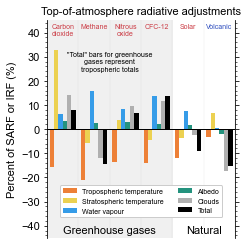

In [27]:
fig, ax1 = pl.subplots()

colors = ['#cc4049','#ed8037','#ecd151','#369ce8','#24937e','#b0b0b0','black']
labels = ['Surface temperature','Tropospheric temperature','Stratospheric temperature','Water vapour','Albedo','Clouds','Total']
for ie, expt in enumerate(['3xCH4', '3xN2O', '9xCFC12', 'Solar', 'Volcanic']):
    if expt in ['2xCO2', '3xCH4', '3xN2O', '9xCFC12']:
        ax1.bar(0.15+ie+1, 100*(ta_trop/SARF).mean()[expt], 0.14, color=colors[1], zorder=3)
        ax1.bar(0.29+ie+1, 100*(ta_strat/SARF).mean()[expt], 0.14, color=colors[2], zorder=3)
        ax1.bar(0.43+ie+1, 100*(hus/SARF).mean()[expt], 0.14, color=colors[3], zorder=3)
        ax1.bar(0.57+ie+1, 100*(alb/SARF).mean()[expt], 0.14, color=colors[4], zorder=3)
        ax1.bar(0.71+ie+1, 100*(cloud/SARF).mean()[expt], 0.14, color=colors[5], zorder=3)
        ax1.bar(0.85+ie+1, 100*(total_trop/SARF).mean()[expt], 0.14, color=colors[6], zorder=3)
    elif expt in ['Solar', 'Volcanic']:
        ax1.bar(0.15+ie+1, 100*(ta_trop/IRF).mean()[expt], 0.14, color=colors[1], zorder=3)
        ax1.bar(0.29+ie+1, 100*(ta_strat/IRF).mean()[expt], 0.14, color=colors[2], zorder=3)
        ax1.bar(0.43+ie+1, 100*(hus/IRF).mean()[expt], 0.14, color=colors[3], zorder=3)
        ax1.bar(0.57+ie+1, 100*(alb/IRF).mean()[expt], 0.14, color=colors[4], zorder=3)
        ax1.bar(0.71+ie+1, 100*(cloud/IRF).mean()[expt], 0.14, color=colors[5], zorder=3)
        ax1.bar(0.85+ie+1, 100*(RA/IRF).mean()[expt], 0.14, color=colors[6], zorder=3)
#    else:
#        ax1.bar(0.15+ie+1, 100*(ta_trop/SARF).mean()[expt], 0.14, color=colors[1], zorder=3)
#        ax1.bar(0.29+ie+1, 100*(ta_strat/SARF).mean()[expt], 0.14, color=colors[2], zorder=3)
#        ax1.bar(0.43+ie+1, 100*(hus/SARF).mean()[expt], 0.14, color=colors[3], zorder=3)
#        ax1.bar(0.57+ie+1, 100*(alb/SARF).mean()[expt], 0.14, color=colors[4], zorder=3)
#        ax1.bar(0.71+ie+1, 100*(cloud/SARF).mean()[expt], 0.14, color=colors[5], zorder=3)
#        ax1.bar(0.85+ie+1, 100*(RA/SARF).mean()[expt], 0.14, color=colors[6], zorder=3)
    if expt in ['Volcanic', '5xSO4']:
        textcolor='#304fbf'
    else:
        textcolor='#cc4049'
    ax1.text(0.5+ie+1, 44, expt_names[expt], ha='center', va='top', fontsize=7, color=textcolor)
ie=0
expt='2xCO2'
ax1.bar(0.15, 100*(ta_trop/SARF).mean()[expt], 0.14, color=colors[1], zorder=3, label=labels[1])
ax1.bar(0.29, 100*(ta_strat/SARF).mean()[expt], 0.14, color=colors[2], zorder=3, label=labels[2])
ax1.bar(0.43, 100*(hus/SARF).mean()[expt], 0.14, color=colors[3], zorder=3, label=labels[3])
ax1.bar(0.57, 100*(alb/SARF).mean()[expt], 0.14, color=colors[4], zorder=3, label=labels[4])
ax1.bar(0.71, 100*(cloud/SARF).mean()[expt], 0.14, color=colors[5], zorder=3, label=labels[5])
ax1.bar(0.85, 100*(total_trop/SARF).mean()[expt], 0.14, color=colors[6], zorder=3, label=labels[6])
ax1.text(0.5, 44, expt_names[expt], ha='center', va='top', fontsize=7, color='#cc4049')

ax1.text(2, -44, 'Greenhouse gases', size=11, va='bottom', ha='center')
#ax1.text(6, -118, 'Aerosols', size=11, va='bottom', ha='center')
ax1.text(5, -44, 'Natural', size=11, va='bottom', ha='center')

ax1.set_ylabel('Percent of SARF or IRF (%)')

ax1.axhline(0, color='k', lw=1, zorder=4)

for x in range(1,8):
    ax1.axvline(x,lw=0.2,color='#d0d0d0')

mn,mx = ax1.get_ylim()
backfill = [0,4,4,6]
fillind  = [1,1,0,0]
ax1.fill_between(backfill, -120, 100, where=fillind, color='#f0f0f0', zorder=0.6)
ax1.legend(loc='lower center', framealpha=1, fontsize=7, ncol=2, frameon=True, bbox_to_anchor=[0.5,0.08])
ax1.set_ylim(-45,45)
ax1.set_xlim(0,6)
#ax1.grid(axis='y', zorder=-11, lw=0.5)

ax1.set_title('Top-of-atmosphere radiative adjustments', fontsize=11)
ax1.text(2, 28, '"Total" bars for greenhouse\ngases represent\ntropospheric totals', size=7, ha='center', va='center')


fig.tight_layout()

pl.savefig('../figures/fig7.4.png', dpi=300)
pl.savefig('../figures/fig7.4.pdf')